<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/emcee-CaseB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
from matplotlib import cm
import emcee
import time
import corner
import arviz as az
import timeit





In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


In [0]:

def ClassMatrix(x, means):
    temp = np.zeros( shape=(x.shape[0], means.shape[0]) )
    #q = 9.21034 / 100
    for i in range( x.shape[0]):
        temp2=np.zeros( means.shape[0] )
        for j in range( means.shape[0] ):
            temp2[j] =np.dot( x[i] - means[j], x[i] - means[j] )
        index_min = np.argmin(temp2 )
        temp[i][index_min]=1
    return temp

#estimation of weights
def weights(x, means, size):
    #take a sample of size=size and calculate the weights
    indexes = np.random.choice( np.arange( 0, len(x) ), size=size, replace=False )
    temp=ClassMatrix(x[indexes], means)
    return np.mean(temp, 0)


def AFER( fw, tw):
    '''Average frecuency error rate 
    fw: frequency weight
    tw: true weight 
    Calculate \sum| fw-tw | '''
    return np.sum( np.abs(  fw-tw ) )
    

def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb: array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])

    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()    


num_mixtures = 20 #number of mixture components
dim = 2  # mixture of bivariate Gaussians


mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.5],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])




#Log target f(x)
def logf(x):
    if(x[0]>0 and x[0]>0 and x[0]<10 and x[1]<10   ):
      w = 1/np.sqrt(np.sum(np.square((mu-[5,5])),1))
      v = np.sqrt(np.sum(np.square((mu-[5,5])),1))/20
      return np.log(np.sum((w/v)*np.exp(-1.0/(2.0*v)*np.sum(np.square(x-mu),1))))
    else:
      return -np.inf 



class emcee_target:
    count = 0
    
    def logf(self,x):
      if(x[0]>0 and x[0]>0 and x[0]<10 and x[1]<10   ):
        w = 1/np.sqrt(np.sum(np.square((mu-[5,5])),1))
        v = np.sqrt(np.sum(np.square((mu-[5,5])),1))/20
        return np.log(np.sum((w/v)*np.exp(-1.0/(2.0*v)*np.sum(np.square(x-mu),1))))
      else:
        return -np.inf 
      
    def __call__(self, x):
        self.count += 1
        return self.logf(x)


def Analysis(x):
    mean=np.mean(x,0)
    var=np.var(x,0)

    ess1 = tfp.mcmc.effective_sample_size(  x[:,0] , filter_beyond_positive_pairs=True)
    ess2 = tfp.mcmc.effective_sample_size(  x[:,1] , filter_beyond_positive_pairs=True)

    ess=min(ess1, ess2)    

    summary= {
        "Mean": mean,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        }
    return summary



In [158]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))


2 CPUs


In [159]:
T=2500000
bi=int(T*0.15)
nwalkers = 50
p0=scipy.stats.uniform.rvs(  loc=0, scale=10, size=(nwalkers, dim)  )


#beautiful multiprocessing in place
#one iteration involves updating every walker

f=emcee_target()
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, dim, f, pool=pool)
    start = time.time()
    sampler.run_mcmc(p0, int( T/nwalkers), progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    




100%|██████████| 50000/50000 [06:20<00:00, 131.55it/s]

Multiprocessing took 380.3 seconds


In [160]:
samples = sampler.get_chain(flat=True) 
ws_emcee=weights(samples, means= mu, size= samples.shape[0] )
print(ws_emcee)


[0.0467304 0.0168984 0.0368936 0.0289532 0.0332728 0.0580792 0.0237812
 0.1871364 0.0676948 0.0726404 0.0551784 0.035956  0.1048068 0.0287264
 0.0206196 0.0365912 0.0210684 0.0255996 0.0709812 0.028392 ]


In [161]:
#modes discovered by 50 different chains

nModes=np.sum(ws_emcee>0)
print('Expected Modes discovered : ', nModes)
print('Likelihood evaluations : ', f.count)
print('Likelihood evaluations per chain: ', f.count/nwalkers)

Expected Modes discovered :  20
Likelihood evaluations :  0
Likelihood evaluations per chain:  0.0


In [162]:
print('Expected AFER: ', AFER(ws_emcee, 1/20) )

Expected AFER:  0.5330343999999999


In [163]:
Analysis(samples)

{'Mean': array([4.67496864, 4.98758344]),
 'Variance': array([3.57703635, 5.8962543 ]),
 'ess': <tf.Tensor: shape=(), dtype=float64, numpy=2443105.267470236>,
 'mVar': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.46413517e-06, 2.41342621e-06])>}

In [0]:
samples2=sampler.get_chain()

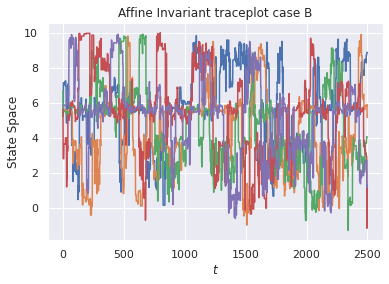

In [165]:
sns.set()
plt.plot(samples2[int(T/nwalkers*0.15 ):10000,0:5,1])
plt.xlabel( r'$t$' )
plt.ylabel( 'State Space' )
plt.title( r'Affine Invariant traceplot case B' )
plt.savefig('traceplot-emceeB.png', dpi=500)    
plt.show()    

In [0]:
xx,yy,Z= fpoints(f= logf ,args=(0,), theta=(), pars=(),
                  lb= np.array([0,0]), upb= np.array([10, 10]) , m=200 ) #takes time :)

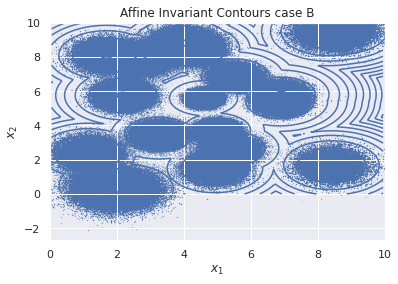

In [168]:

sns.set()
plt.contour( xx, yy, -Z, 10, colors='b' )
plt.scatter( samples[:, 0 ],samples[:, 1 ], s=0.01, zorder=-1 )
plt.xlabel( r'$x_1$' )
plt.ylabel( r'$x_2$' )
plt.title( r'Affine Invariant Contours case B' )
plt.savefig('emceeB.png', dpi=500)    
plt.show()    
